<a href="https://colab.research.google.com/github/jiuyuanx/94812-Application-of-NLP-and-LLM/blob/main/A3-HateSpeech-Classification/HateSpeech_Classification_TransformerEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
!pip install -q torchsummaryX

## **Load Hate Speech Dataset**

In [5]:
df = pd.read_pickle("https://github.com/jiuyuanx/94812-Application-of-NLP-and-LLM/blob/main/A3-HateSpeech-Classification/clean_df.pkl?raw=true")
df

,total_votes,hate_speech_votes,other_votes,label,tweet,clean_tweets
0,3,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...,as a woman you shouldnt complain about clea...
1,3,0,3,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad for cuffin dat ho...
2,3,0,3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg you ever fuck a bitch and she sta to...
3,3,0,3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,she look like a tranny
4,6,0,6,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,the shit you hear about me might be true or...
...,...,...,...,...,...,...
25291,3,0,3,0,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,yous a muthafin lie right his tl is trash ...
25292,3,0,3,0,"you've gone and broke the wrong heart baby, an...",youve gone and broke the wrong hea baby and dr...
25294,3,0,3,0,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat dat nigguh like i aint fu...
25295,6,0,6,0,youu got wild bitches tellin you lies,youu got wild bitches tellin you lies


<Axes: xlabel='hate_speech_votes', ylabel='label'>

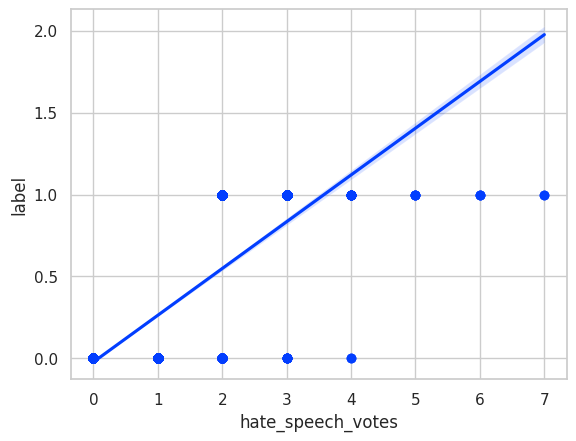

In [377]:
sns.regplot(df[['label','hate_speech_votes']],x='hate_speech_votes',  y='label')

In [13]:
# assigning variables to essential columns
data = df['clean_tweets']
label = df['label']

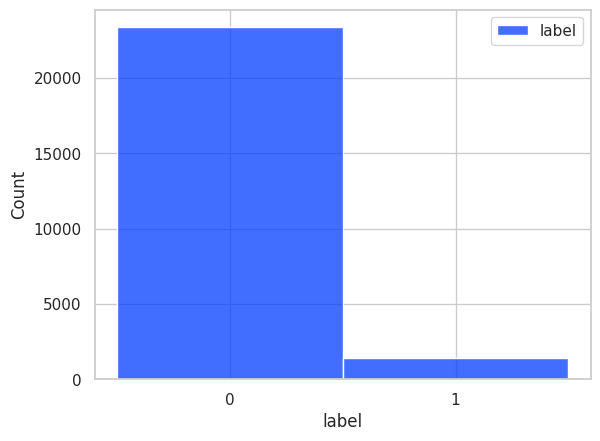

In [381]:
sns.set(style = 'whitegrid', palette='bright')
sns.histplot(pd.DataFrame(label)['label'].apply(lambda x:str(x)), label='label')
plt.legend()

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def process_tweet(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed

processed_data = list(map(process_tweet, data))
len(processed_data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


24783

In [24]:
from nltk.probability import FreqDist
all_tokens = [item for sublist in processed_data for item in sublist]
clean_corpus_freqdist = FreqDist(all_tokens)
# top 20 words in cleaned corpus
clean_corpus_freqdist.most_common(20)

[('bitch', 8227),
 ('bitches', 3083),
 ('like', 2766),
 ('hoes', 2368),
 ('pussy', 2099),
 ('im', 2061),
 ('hoe', 1906),
 ('dont', 1749),
 ('got', 1597),
 ('ass', 1570),
 ('get', 1428),
 ('fuck', 1411),
 ('u', 1280),
 ('shit', 1262),
 ('nigga', 1198),
 ('aint', 1158),
 ('trash', 1142),
 ('lol', 1074),
 ('know', 806),
 ('niggas', 791)]

## **Lemmatization**

In [28]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, PorterStemmer

lemmatizer = WordNetLemmatizer()
lemmatized_data = []

for text in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(word) for word in text])
    lemmatized_data.append(lemmed)
len(lemmatized_data)

[nltk_data] Downloading package wordnet to /root/nltk_data...


24783

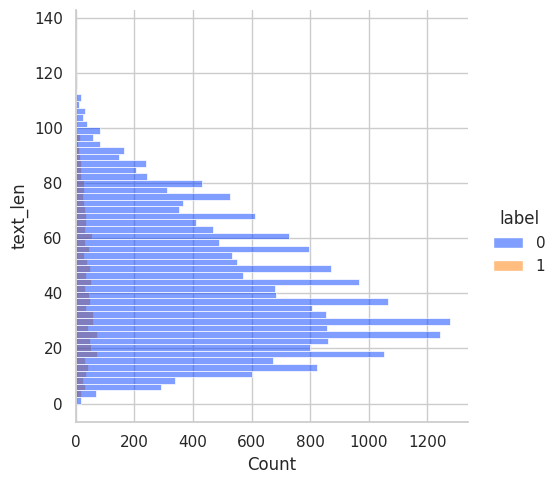

In [42]:
stats = pd.DataFrame({'text':lemmatized_data, 'label':label})
stats['text_len'] = stats['text'].apply(lambda x:len(x))
sns.displot(stats, y='text_len', hue='label')

**We can see the hatespeech has very low percentage in the dataset, so we'll have to do upsampling.
Also majority text has a length under 60. So we'll perform padding and truncation to unsure they all have a length 60, for tensor training by deep learning models.**

## **Bert Tokenizer, Truncate, Pad for Array**

In [ ]:
from transformers import BertTokenizer, BertModel
model_name = 'Hate-speech-CNERG/bert-base-uncased-hatexplain'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert = BertModel.from_pretrained(model_name).to(device)

In [246]:
def tokenize(x):
  out = tokenizer.encode_plus(x,
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=60,    # Truncate or pad to the maximum length
        truncation=True,          # Enable truncation if text is too long
        padding='max_length',     # Pad to the maximum length
        return_tensors='pt'       # Return PyTorch tensors)
  )

  return out

In [248]:
# X_tokenized = [list(tokenize(x).values()) for x in lemmatized_data ]
X_tokenized = [tokenize(x) for x in lemmatized_data ]
# print("shape of one news:", X_tokenized[0][0].shape)
# lemmatized_data[0], label[0], X_tokenized[0]

In [351]:
att_mask = [x['attention_mask'] for  x in X_tokenized]
len(att_mask), att_mask[0]

(24783,
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'))

In [267]:
embeddings = []
for tokens in tqdm(X_tokenized, "Bert inferencing..."):
  tokens.to(device)
  with torch.no_grad():
      outputs = bert(**tokens)
      embeddings.append(outputs.last_hidden_state.squeeze().cpu())
embeddings[0].shape

Bert inferencing...:   0%|          | 0/24783 [00:00<?, ?it/s]

torch.Size([60, 768])

## **Build Transformer Encoder in Pytorch**

In [160]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import gc

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


## **Dataset & Dataloader**

In [354]:
config = {
    'batch_size': 128, # Increase this if your GPU can handle it
    'lr': 1e-4,
    'epochs': 30,
}

In [355]:
class NLPDataset(Dataset):
    def __init__(self, data, label) :
        super().__init__()

        self.data = data
        # print(data)
        # self.input_ids = data[:,0]
        # self.token_type_ids =data[:,1]
        # self.attention_mask = data[:,2]
        self.label = torch.LongTensor(label)

    def __len__(self):
        return self.label.shape[0]

    def __getitem__(self, index):
        # return (torch.LongTensor(self.input_ids[index]).squeeze(), \
        #         torch.LongTensor(self.attention_mask[index]).squeeze()), \
        return self.data[index],self.label[index]

In [356]:
X_train, X_test, y_train, y_test = train_test_split(np.array(embeddings), np.array(label), test_size=0.25, random_state=42)
print("Label count:", np.unique(y_train, return_counts=True))
X_train.shape, y_train.shape

Label count: (array([0, 1]), array([17518,  1069]))


((18587,), (18587,))

Label count: (array([0, 1]), array([17518, 17518]))


((35036,), (35036,))

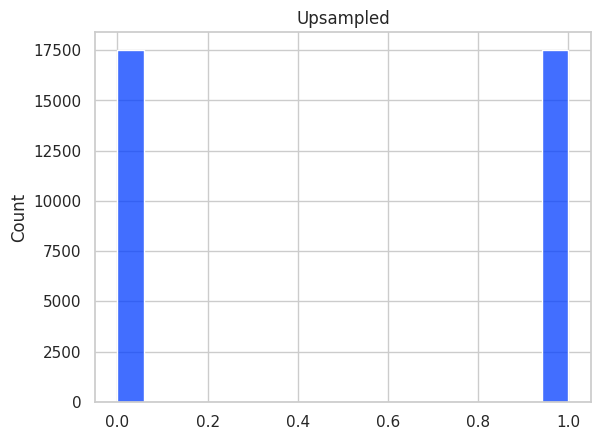

In [358]:
sm = SMOTE(random_state=42)
indices_resampled, y_train = sm.fit_resample(np.arange(X_train.shape[0])[:,np.newaxis], y_train)
X_train = np.squeeze(np.array([X_train[i] for i in indices_resampled]))
print("Label count:", np.unique(y_train, return_counts=True))
sns.histplot(y_train)
plt.title("Upsampled")
X_train.shape, y_train.shape

In [359]:
train_data = NLPDataset(X_train, y_train)
val_data = NLPDataset(X_test, y_test)
len(train_data), len(val_data)

(35036, 6196)

In [360]:
train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = config['batch_size'],
    shuffle=False
)

for batch in train_loader:
    X, y=batch
    print("Sample batch shape:", X.shape, y.shape, y)
    break

Sample batch shape: torch.Size([128, 60, 768]) torch.Size([128]) tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        1, 1, 1, 0, 1, 0, 1, 0])


## **Transformer Encoder**

In [361]:
class PositionalEncoder(nn.Module):
    def __init__(self, dropout= 0.1, max_seq_len = 5000, d_model = 512):

        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_seq_len).unsqueeze(1)
        exp_input = torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model)
        div_term = torch.exp(exp_input) # Returns a new tensor with the exponential of the elements of exp_input
        pe = torch.zeros(max_seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term) # torch.Size([target_seq_len, dim_val])
        pe = pe.unsqueeze(0).transpose(0, 1) # torch.Size([target_seq_len, input_size, dim_val])
        # register that pe is not a model parameter
        self.register_buffer('pe', pe)

    def forward(self, x) :
        add = self.pe[:x.size(1), :].squeeze(1)
        x = x + add
        return self.dropout(x)


In [362]:
class Transformer(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, nhead=8, num_encoder_layers=6, dropout=0.1,encode_seq_len=60):
        super(Transformer, self).__init__()
        self.nhead=nhead
        self.d_model=d_model
        # self.embedding = nn.Embedding(num_embeddings= len(tokenizer), embedding_dim=d_model, padding_idx=0)
        # self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True, padding_idx=0)
        # self.fc = nn.Linear(glove_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=d_model, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        self.positional_encoding_layer = PositionalEncoder(dropout, encode_seq_len, d_model )
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.LeakyReLU(),
            nn.Linear(d_model, output_dim)

        )
        # self.linear = nn.Linear(d_model*encode_seq_len, output_dim)

    def forward(self, x):
        # input_ids      = x[0].to(device)
        # attention_mask = x[1].to(device)
        # attention_mask = attention_mask.broadcast_to(attention_mask.shape[0], attention_mask.shape[1],attention_mask.shape[1])
        out = x #Batch, length, embeddings
        # out = self.embedding(input_ids)
        # out = self.positional_encoding_layer(out)
        out = self.encoder(out).mean(dim=1)
        # output = self.encoder(out, src_key_padding_mask=attention_mask.bool()).mean(dim=1)

        output = self.mlp(out)

        return output


In [363]:
#TODO: tune model parameters
model=Transformer(input_dim=768, output_dim=2, d_model=768, nhead=12,
                  num_encoder_layers=2,
                  dropout=0.3, encode_seq_len=50).to(device)
# print(x.size)
for X, y in train_loader:
    X = X.to(device)
    y = y.to(device)
    print("x shape:", X[0].shape, "y shape:", y.shape)
    out=model(X)
    print("out shape:", out.shape)
    summary(model,X)
    break

x shape: torch.Size([60, 768]) y shape: torch.Size([128])
out shape: torch.Size([128, 2])
                                     Kernel Shape    Output Shape    Params  \
Layer                                                                         
0_encoder.layers.0.Dropout_dropout1             -  [128, 60, 768]         -   
1_encoder.layers.0.LayerNorm_norm1          [768]  [128, 60, 768]    1.536k   
2_encoder.layers.0.Linear_linear1      [768, 768]  [128, 60, 768]  590.592k   
3_encoder.layers.0.Dropout_dropout              -  [128, 60, 768]         -   
4_encoder.layers.0.Linear_linear2      [768, 768]  [128, 60, 768]  590.592k   
5_encoder.layers.0.Dropout_dropout2             -  [128, 60, 768]         -   
6_encoder.layers.0.LayerNorm_norm2          [768]  [128, 60, 768]    1.536k   
7_encoder.layers.1.Dropout_dropout1             -  [128, 60, 768]         -   
8_encoder.layers.1.LayerNorm_norm1          [768]  [128, 60, 768]    1.536k   
9_encoder.layers.1.Linear_linear1      [7

In [364]:
optimizer   = torch.optim.AdamW(model.parameters(), lr= config['lr'], weight_decay = 1e-3)
criterion   = torch.nn.CrossEntropyLoss(reduction="mean",label_smoothing=0.05)
# scaler      = torch.cuda.amp.GradScaler()
scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.85)
print("loss:", criterion(out, y.to(device)))

loss: tensor(0.6907, device='cuda:0', grad_fn=<AddBackward0>)


In [365]:
def train():
      model.train() # set to training mode
      model.to(device)
      train_plot=[]

      batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      total_loss        = 0.0
      num_correct = 0
      predictions = []
      true_labels = []

      for i, batch in enumerate(train_loader):
          optimizer.zero_grad()
          X, y = batch
          X = X.to(device)
          y = y.to(device)
          y_pred = model(X)

          loss = criterion(y_pred, y)
          loss.backward()

          # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          optimizer.step()

          train_plot.append(loss.item())
          total_loss += loss.item()
          num_correct     += int((torch.argmax(y_pred, axis=1) == y).sum())

          predictions.append(y_pred.argmax(1).int().cpu().detach().numpy())
          true_labels.append(y.cpu().detach().numpy())

          batch_bar.set_postfix(
              acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
              loss="{:.04f}".format(total_loss/(i+1)),
              lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
              num_correct = num_correct,
              # teacher_time="{:.04f}".format(teach/10)
               )
          batch_bar.update()


          del X,y
          torch.cuda.empty_cache()

      batch_bar.close()
      acc         = 100 * num_correct / (config['batch_size']* len(train_loader))
      total_loss  = float(total_loss / len(train_loader))

      return acc, total_loss, np.concatenate(predictions), np.concatenate(true_labels)

def validate():
      model.eval() # set to training mode
      model.to(device)

      batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')
      total_loss        = 0.0
      num_correct = 0
      predictions = []
      true_labels = []

      for i, batch in enumerate(val_loader):
          optimizer.zero_grad()
          X, y = batch

          X = X.to(device)
          y = y.to(device)
          y_pred = model(X)

          val_loss = criterion(y_pred, y)
          predictions.append(y_pred.argmax(1).int().cpu().detach().numpy())
          true_labels.append(y.cpu().detach().numpy())

          total_loss += val_loss.item()
          num_correct     += int((torch.argmax(y_pred, axis=1) == y).sum())

          batch_bar.set_postfix(
              acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
              loss="{:.04f}".format(total_loss/(i+1)),
              num_correct = num_correct
               )
          batch_bar.update()

          del X,y
          torch.cuda.empty_cache()

      batch_bar.close()
      acc         = 100 * num_correct / (config['batch_size']* len(val_loader))
      total_loss  = float(total_loss / len(val_loader))

      return acc, total_loss, np.concatenate(predictions), np.concatenate(true_labels)



## **Train Loop**

In [366]:
# optimizer.param_groups[0]['lr']=1e-3
train_acc_plot=[]
train_loss_plot=[]
val_acc_plot=[]
val_loss_plot=[]
train_precision_plot=[]
train_recall_plot=[]
val_precision_plot=[]
val_recall_plot=[]
num_epochs=30
for epoch in range(0, num_epochs):

    # Call train and validate
    print("\nEpoch: {}/{}".format(epoch+1, num_epochs))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss, train_predictions, train_true_labels            = train()
    train_precision_plot.append(precision_score(train_predictions, train_true_labels))
    train_recall_plot.append(recall_score(train_predictions, train_true_labels))


    train_loss_plot.append(train_loss)
    train_acc_plot.append(train_acc)
    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Precision {:.04f}\t Recall {:.04f}\t Learning Rate {:.08f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        precision_score(train_predictions, train_true_labels),
        recall_score(train_predictions, train_true_labels),
        curr_lr))

    val_acc, val_loss, val_predictions, val_true_labels                = validate()
    val_precision_plot.append(precision_score(val_predictions, val_true_labels))
    val_recall_plot.append(recall_score(val_predictions, val_true_labels))

    val_loss_plot.append(val_loss)
    val_acc_plot.append(val_acc)
    scheduler.step()
    print("Val Acc {:.04f}%\t Val Loss {:.04f}\t Precision {:.04f}\t Recall {:.04f}".format(val_acc, val_loss,\
                                                       precision_score(val_predictions, val_true_labels),\
                                                       recall_score(val_predictions, val_true_labels)))



Epoch: 1/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 1/30: 
Train Acc 54.2427%	 Train Loss 0.6852	 Precision 0.4464	 Recall 0.5533	 Learning Rate 0.00010000


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 68.1441%	 Val Loss 0.6797	 Precision 0.8089	 Recall 0.1361

Epoch: 2/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 2/30: 
Train Acc 55.2977%	 Train Loss 0.6782	 Precision 0.4099	 Recall 0.5751	 Learning Rate 0.00008500


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 41.2149%	 Val Loss 0.7377	 Precision 0.9335	 Recall 0.0859

Epoch: 3/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 3/30: 
Train Acc 56.4068%	 Train Loss 0.6738	 Precision 0.4044	 Recall 0.5951	 Learning Rate 0.00007225


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 64.5408%	 Val Loss 0.6925	 Precision 0.8227	 Recall 0.1247

Epoch: 4/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 4/30: 
Train Acc 57.7469%	 Train Loss 0.6664	 Precision 0.4111	 Recall 0.6172	 Learning Rate 0.00006141


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 78.2207%	 Val Loss 0.6482	 Precision 0.7202	 Recall 0.1794

Epoch: 5/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 5/30: 
Train Acc 59.1212%	 Train Loss 0.6583	 Precision 0.4352	 Recall 0.6337	 Learning Rate 0.00005220


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 55.0064%	 Val Loss 0.6973	 Precision 0.8061	 Recall 0.0981

Epoch: 6/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 6/30: 
Train Acc 60.9375%	 Train Loss 0.6481	 Precision 0.4763	 Recall 0.6501	 Learning Rate 0.00004437


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 80.3731%	 Val Loss 0.6065	 Precision 0.6593	 Recall 0.1874

Epoch: 7/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 7/30: 
Train Acc 62.5941%	 Train Loss 0.6369	 Precision 0.5184	 Recall 0.6615	 Learning Rate 0.00003771


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 88.4566%	 Val Loss 0.5066	 Precision 0.5125	 Recall 0.2816

Epoch: 8/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 8/30: 
Train Acc 64.1994%	 Train Loss 0.6252	 Precision 0.5510	 Recall 0.6747	 Learning Rate 0.00003206


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 83.9445%	 Val Loss 0.5427	 Precision 0.5346	 Recall 0.2019

Epoch: 9/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 9/30: 
Train Acc 65.5309%	 Train Loss 0.6116	 Precision 0.5740	 Recall 0.6866	 Learning Rate 0.00002725


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 72.2417%	 Val Loss 0.6001	 Precision 0.6177	 Recall 0.1274

Epoch: 10/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 10/30: 
Train Acc 66.9822%	 Train Loss 0.6007	 Precision 0.6057	 Recall 0.6959	 Learning Rate 0.00002316


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 75.4305%	 Val Loss 0.5844	 Precision 0.6233	 Recall 0.1448

Epoch: 11/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 11/30: 
Train Acc 67.9345%	 Train Loss 0.5915	 Precision 0.6240	 Recall 0.7028	 Learning Rate 0.00001969


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 75.1754%	 Val Loss 0.5680	 Precision 0.5485	 Recall 0.1306

Epoch: 12/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 12/30: 
Train Acc 68.8384%	 Train Loss 0.5825	 Precision 0.6392	 Recall 0.7101	 Learning Rate 0.00001673


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 72.4490%	 Val Loss 0.5988	 Precision 0.6454	 Recall 0.1326

Epoch: 13/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 13/30: 
Train Acc 69.7365%	 Train Loss 0.5755	 Precision 0.6542	 Recall 0.7171	 Learning Rate 0.00001422


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 66.7092%	 Val Loss 0.6342	 Precision 0.6510	 Recall 0.1108

Epoch: 14/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 14/30: 
Train Acc 70.1585%	 Train Loss 0.5693	 Precision 0.6630	 Recall 0.7196	 Learning Rate 0.00001209


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 77.7423%	 Val Loss 0.5442	 Precision 0.5623	 Recall 0.1487

Epoch: 15/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 15/30: 
Train Acc 70.5663%	 Train Loss 0.5648	 Precision 0.6685	 Recall 0.7233	 Learning Rate 0.00001028


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 79.5281%	 Val Loss 0.5185	 Precision 0.5208	 Recall 0.1537

Epoch: 16/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 16/30: 
Train Acc 71.0111%	 Train Loss 0.5613	 Precision 0.6786	 Recall 0.7254	 Learning Rate 0.00000874


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 72.0185%	 Val Loss 0.5775	 Precision 0.5152	 Recall 0.1101

Epoch: 17/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 17/30: 
Train Acc 71.4074%	 Train Loss 0.5552	 Precision 0.6847	 Recall 0.7286	 Learning Rate 0.00000743


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 74.9043%	 Val Loss 0.5576	 Precision 0.5623	 Recall 0.1316

Epoch: 18/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 18/30: 
Train Acc 71.5271%	 Train Loss 0.5530	 Precision 0.6879	 Recall 0.7289	 Learning Rate 0.00000631


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 72.4330%	 Val Loss 0.5805	 Precision 0.5789	 Recall 0.1222

Epoch: 19/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 19/30: 
Train Acc 71.8208%	 Train Loss 0.5515	 Precision 0.6896	 Recall 0.7326	 Learning Rate 0.00000536


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 69.7066%	 Val Loss 0.5997	 Precision 0.5873	 Recall 0.1123

Epoch: 20/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 20/30: 
Train Acc 71.7838%	 Train Loss 0.5491	 Precision 0.6970	 Recall 0.7284	 Learning Rate 0.00000456


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 72.4011%	 Val Loss 0.5789	 Precision 0.5873	 Recall 0.1234

Epoch: 21/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 21/30: 
Train Acc 72.1744%	 Train Loss 0.5460	 Precision 0.6963	 Recall 0.7348	 Learning Rate 0.00000388


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 71.7156%	 Val Loss 0.5837	 Precision 0.5817	 Recall 0.1195

Epoch: 22/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 22/30: 
Train Acc 72.0974%	 Train Loss 0.5452	 Precision 0.7007	 Recall 0.7314	 Learning Rate 0.00000329


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 72.3533%	 Val Loss 0.5849	 Precision 0.5900	 Recall 0.1236

Epoch: 23/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 23/30: 
Train Acc 72.6306%	 Train Loss 0.5435	 Precision 0.7027	 Recall 0.7387	 Learning Rate 0.00000280


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 74.4420%	 Val Loss 0.5618	 Precision 0.5651	 Recall 0.1296

Epoch: 24/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 24/30: 
Train Acc 72.4367%	 Train Loss 0.5434	 Precision 0.7016	 Recall 0.7362	 Learning Rate 0.00000238


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 71.4923%	 Val Loss 0.5832	 Precision 0.5679	 Recall 0.1164

Epoch: 25/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 25/30: 
Train Acc 72.5422%	 Train Loss 0.5412	 Precision 0.7076	 Recall 0.7349	 Learning Rate 0.00000202


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 75.5740%	 Val Loss 0.5466	 Precision 0.5485	 Recall 0.1328

Epoch: 26/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 26/30: 
Train Acc 72.5935%	 Train Loss 0.5412	 Precision 0.7070	 Recall 0.7359	 Learning Rate 0.00000172


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 72.4330%	 Val Loss 0.5800	 Precision 0.5900	 Recall 0.1240

Epoch: 27/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 27/30: 
Train Acc 72.6848%	 Train Loss 0.5400	 Precision 0.7074	 Recall 0.7372	 Learning Rate 0.00000146


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 74.7290%	 Val Loss 0.5575	 Precision 0.5623	 Recall 0.1306

Epoch: 28/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 28/30: 
Train Acc 72.6677%	 Train Loss 0.5401	 Precision 0.7082	 Recall 0.7365	 Learning Rate 0.00000124


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 72.7200%	 Val Loss 0.5774	 Precision 0.5789	 Recall 0.1235

Epoch: 29/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 29/30: 
Train Acc 72.8672%	 Train Loss 0.5390	 Precision 0.7108	 Recall 0.7383	 Learning Rate 0.00000106


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 72.8316%	 Val Loss 0.5753	 Precision 0.5789	 Recall 0.1240

Epoch: 30/30


Train:   0%|          | 0/274 [00:00<?, ?it/s]


Epoch 30/30: 
Train Acc 72.7418%	 Train Loss 0.5384	 Precision 0.7084	 Recall 0.7376	 Learning Rate 0.00000090


Train:   0%|          | 0/49 [00:00<?, ?it/s]

Val Acc 74.4739%	 Val Loss 0.5588	 Precision 0.5651	 Recall 0.1298


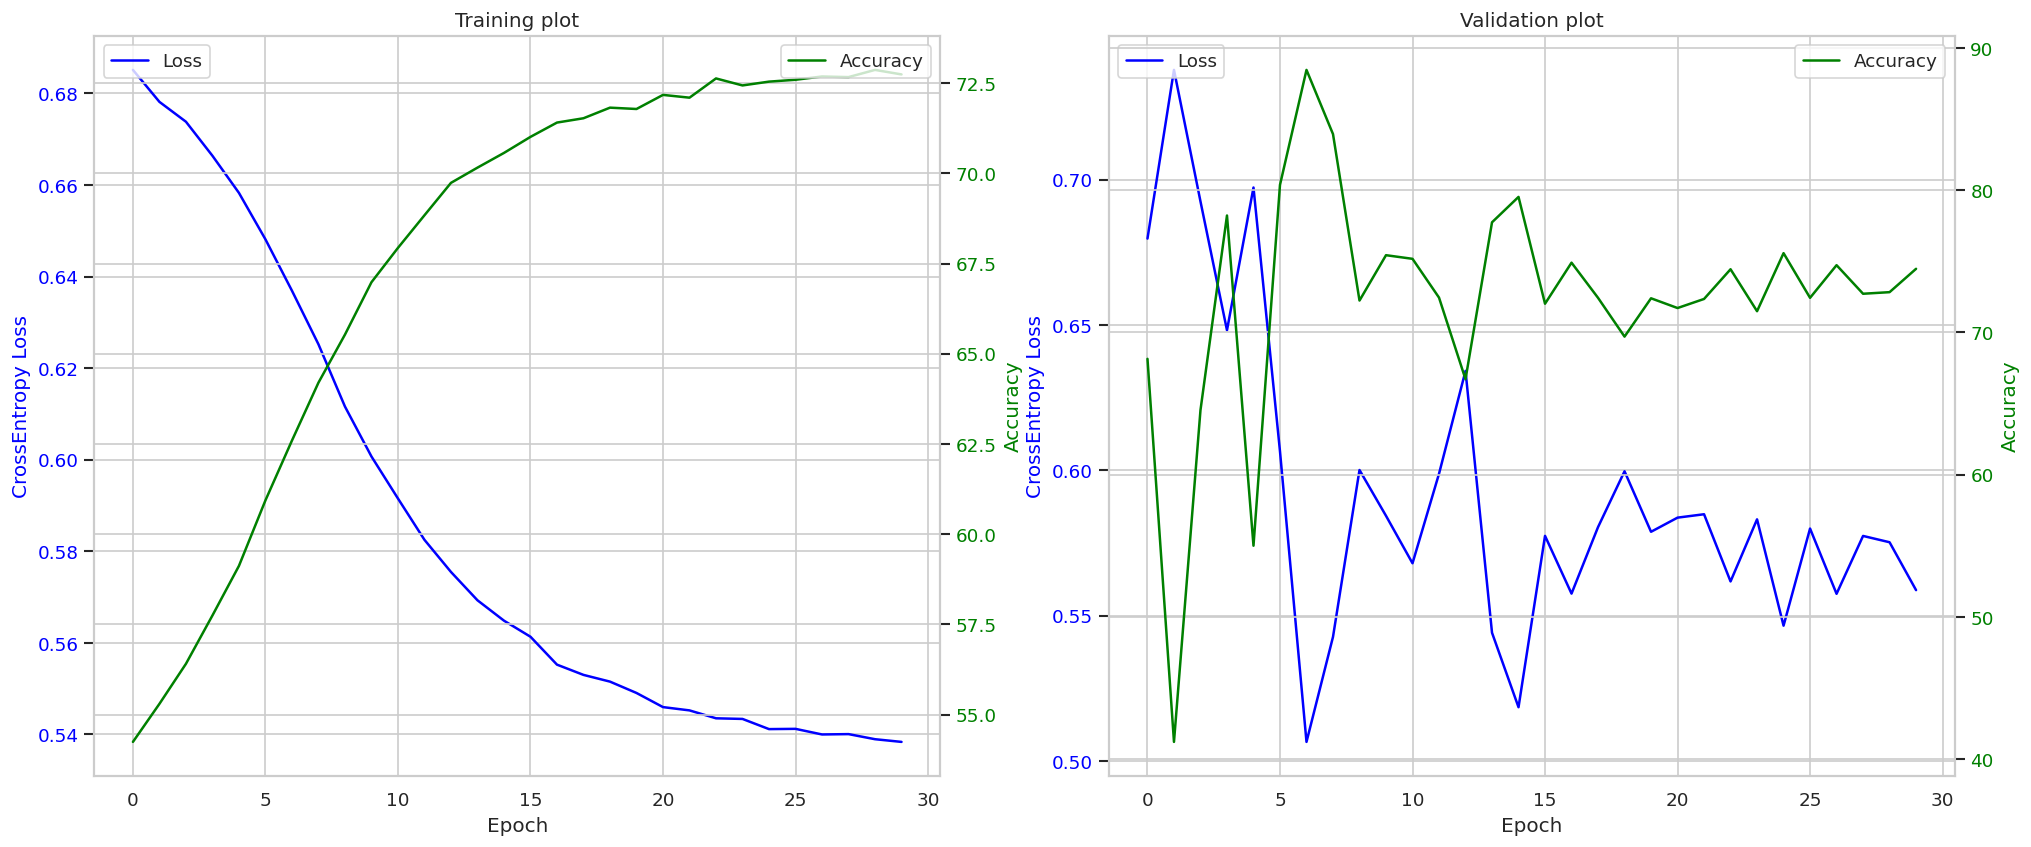

In [367]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=120)

# Training Plot
ax1 = ax[0]
ax1.plot(train_loss_plot, label='Loss', color='blue')
ax1.set_ylabel("CrossEntropy Loss", color='blue')
ax1.set_xlabel("Epoch")
ax1.set_title("Training plot")
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the accuracy
ax2 = ax1.twinx()
ax2.plot(train_acc_plot, label='Accuracy', color='green')
ax2.set_ylabel("Accuracy", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Validation Plot
ax3 = ax[1]
ax3.plot(val_loss_plot, label='Loss', color='blue')
ax3.set_ylabel("CrossEntropy Loss", color='blue')
ax3.set_xlabel("Epoch")
ax3.set_title("Validation plot")
ax3.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the accuracy
ax4 = ax3.twinx()
ax4.plot(val_acc_plot, label='Accuracy', color='green')
ax4.set_ylabel("Accuracy", color='green')
ax4.tick_params(axis='y', labelcolor='green')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='upper left')
ax4.legend(loc='upper right')

plt.show()

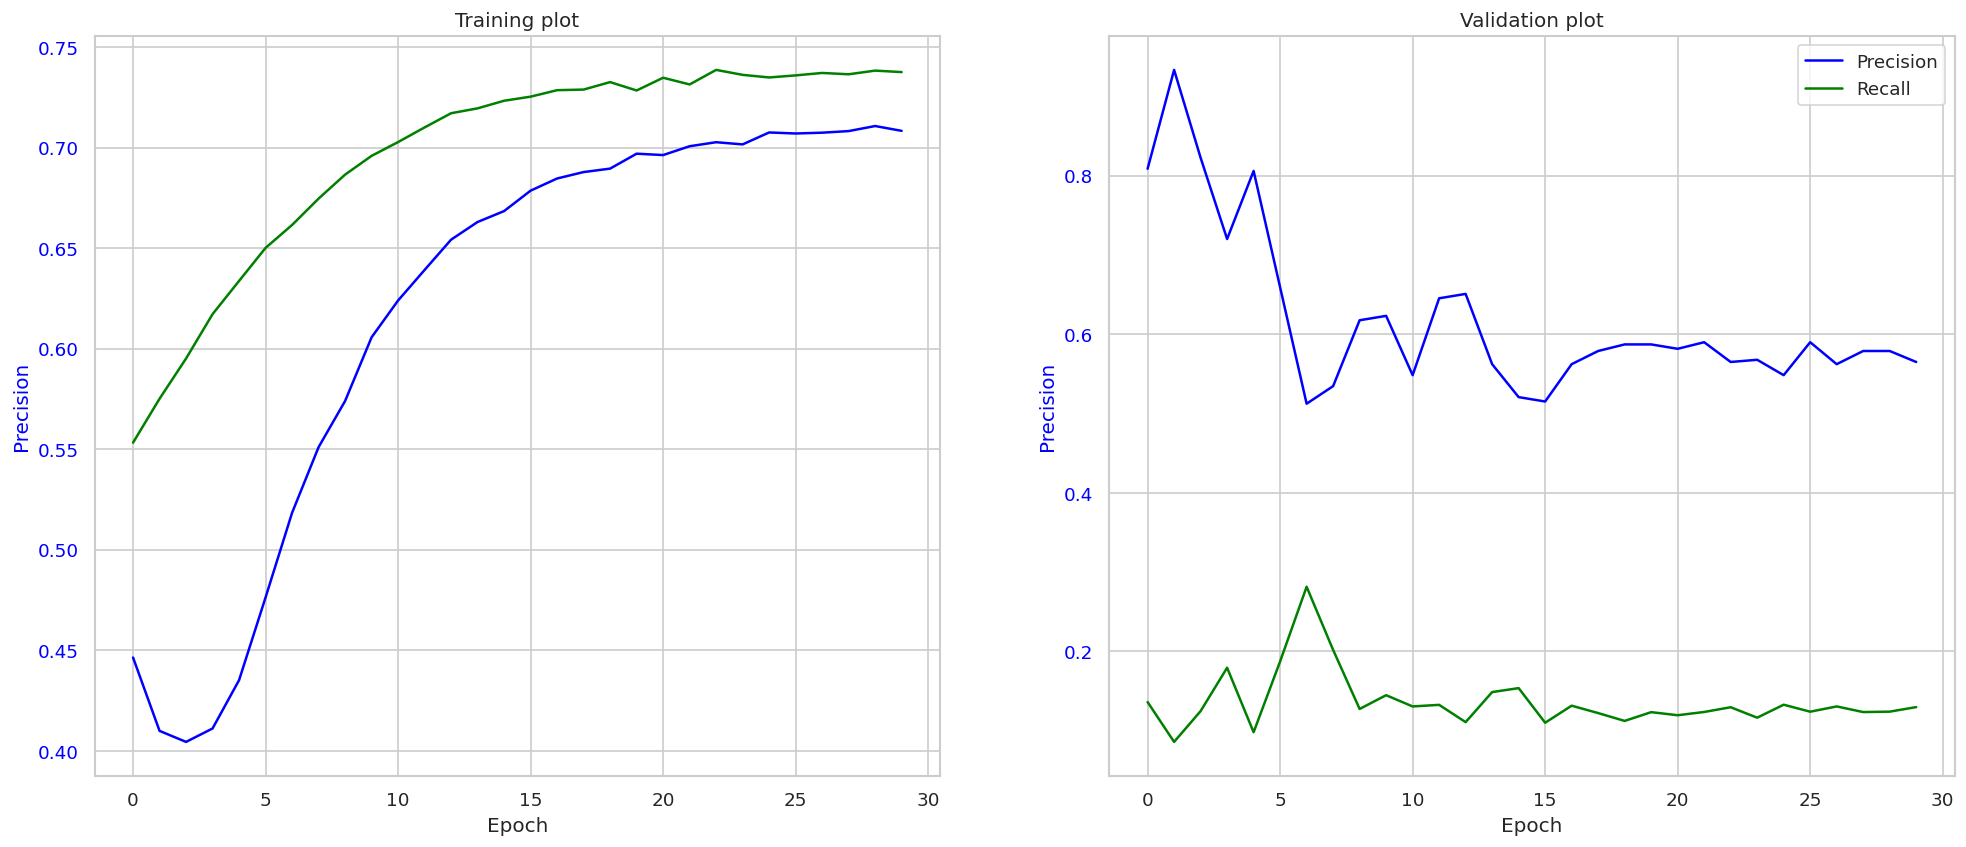

In [368]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=120)

# Training Plot
ax1 = ax[0]
ax1.plot(train_precision_plot, label='Precision', color='blue')
ax1.plot(train_recall_plot, label='Recall', color='green')
ax1.set_ylabel("Precision", color='blue')
ax1.set_xlabel("Epoch")
ax1.set_title("Training plot")
ax1.tick_params(axis='y', labelcolor='blue')


# Validation Plot
ax3 = ax[1]
ax3.plot(val_precision_plot, label='Precision', color='blue')
ax3.plot(val_recall_plot, label='Recall', color='green')
ax3.set_ylabel("Precision", color='blue')
ax3.set_xlabel("Epoch")
ax3.set_title("Validation plot")
ax3.tick_params(axis='y', labelcolor='blue')

plt.legend()

plt.show()

In [369]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([5835,  361]))

**Because Hate Speech consists only 5% of our dataset. Predicting all data as non-hate can give you a accuracy 95%, but we fail to detect hateful speech. Therefore, we have to balance precision and recall. The model at the beginning has a high precision around 90% percent by predicting almost all data to be 0(non-hate), and the recall is around 5%(fail to detect hate). By training the model, accuracy is getting lower then rise and we are getting a lower precision higher accuracy and recall**

**Training: Precision 0.7074	 Recall 0.7372\
Validation: Precision 0.5623	 Recall 0.1306**

The recall does not increase a lot says that our model does not increase its ability in detecting hate speech very much.